In [1]:
from uniprobe_data import *
from sqlalchemy import func
from sqlalchemy import distinct

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggstyle')

In [3]:
import numpy as np

import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
# make dendrograms black rather than letting scipy color them
hierarchy.set_link_color_palette(['black'])

In [4]:
def fasta_iter(fastafile):
    """
    Iterator of the records present in a .fasta file. Each record is yielded as
    a tuple containg the title line (without '>') and the sequence itself.
    """
    on_open_record = False
    with open(fastafile, 'r') as fasta:
        for line in fasta:
            line = line.strip()
            if len(line) == 0:
                continue
            elif line[0] == '#':
                continue
            elif line[0] == '>':
                # close old record
                if on_open_record:
                    yield title, sequence.upper()
                # new record
                title = line[1:].rstrip()
                sequence = ''
                on_open_record = True
            else:
                sequence += line.rstrip()
    if on_open_record:
        yield title, sequence.upper()

In [5]:
uniprot_idx = {rec[0].split('|')[1]: i for i, rec in enumerate(fasta_iter('uniprot_seq.fasta'))}
idx_uniprot = {i: rec[0].split('|')[1] for i, rec in enumerate(fasta_iter('uniprot_seq.fasta'))}
l = len(uniprot_idx)

## Species

In [6]:
__s = dict()
for gene_data in session.query(GeneData):
    __s[gene_data.uniprot] = gene_data.species

species_dist = np.zeros(l * l).reshape(l, l) + 1.0

for i in range(l):
    for j in range(l):
        if __s[idx_uniprot[i]] == __s[idx_uniprot[j]]:
            species_dist[i][j] = 0.0

(-0.01, 1.01)

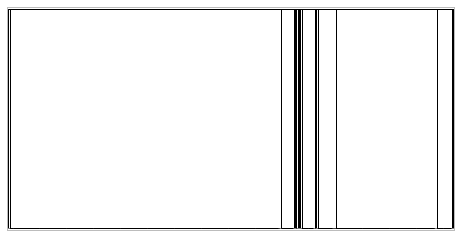

In [7]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

species_clusters = hierarchy.linkage(distance.squareform(species_dist), method='complete')
species_dendo = hierarchy.dendrogram(species_clusters, color_threshold=np.inf, no_plot=False, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.01, 1.01)

[]

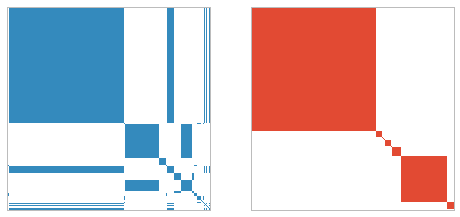

In [8]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
bounds=[0, 0.5, 1]
norm = mpl.colors.Normalize(bounds, cmap.N)
ax[0].imshow(species_dist, interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])
bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1].imshow(species_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[1].set_xticks([])
ax[1].set_yticks([])

## Blast

In [9]:
def blast_fmt6_iter(blastfile):
    """
    Iterator of the blast query present in a output file from blast in format 6.
    Returns a tuple containing the query seq id, the db seq id and the e-score.
    """
    with open(blastfile, 'r') as blast:
        for line in blast:
            word = line.split()
            yield word[0].split('|')[1], word[1].split('|')[1], float(word[-2])

In [10]:
import numpy as np
escores = np.zeros(l * l).reshape(l, l) + 10.0

for rec in blast_fmt6_iter('uniprot_seq.blast'):
    escores[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = rec[2]

In [11]:
# e-score a vs a should be 0.0
for i in range(l):
    escores[i, i] = 0.0
# make symmetric
escores = np.maximum(escores, escores.T)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


[]

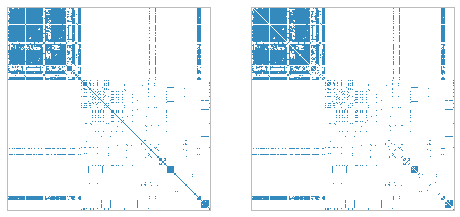

In [12]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
bounds=[0, 1e-4, 10]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(escores, interpolation='nearest', cmap=cmap, norm=norm)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap(['white', plt.rcParams['axes.color_cycle'][1]])
bounds=[-1, 4, 180]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1].imshow(-np.log10(escores), interpolation='nearest', cmap=cmap, norm=norm)
ax[1].set_xticks([])
ax[1].set_yticks([])

(-0.1, 10.1)

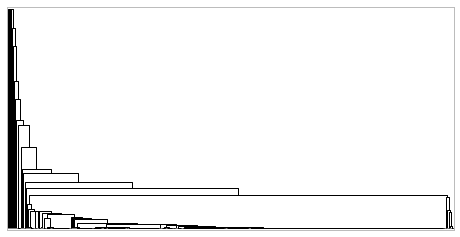

In [13]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

escores_clusters = hierarchy.linkage(distance.squareform(escores), method='single')
escores_dendo = hierarchy.dendrogram(escores_clusters, color_threshold=np.inf, no_plot=False, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.1, 10.1)

[]

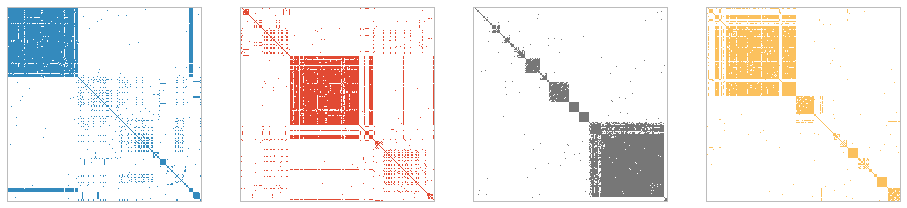

In [88]:
f, ax = plt.subplots(1, 4, figsize=(16, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
ax[0].imshow(escores, interpolation='nearest', cmap=cmap)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])
ax[1].imshow(escores[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap)
ax[1].set_xticks([])
ax[1].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][3], 'white'])
ax[2].imshow(escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap)
ax[2].set_xticks([])
ax[2].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][4], 'white'])
ax[3].imshow(escores[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap)
ax[3].set_xticks([])
ax[3].set_yticks([])

## Seq identity, similarity, gaps

In [29]:
def algn_iter(algnfile):
    """
    
    Returns a tuple containing identifiers of the two sequences being compared
    and two additional tuples containing, respectivelly, the local identity, 
    similarity and gap percentage, and the global identity, similarity and gap percentage.
    """
    with open(algnfile, 'r') as algn:
        for line in algn:
            word = line.split()
            yield word[0].split('|')[1], word[1].split('|')[1],\
                (float(word[2]), float(word[3]), float(word[4])),\
                (float(word[5]), float(word[6]), float(word[7]))

In [30]:
import numpy as np
local_dist = np.zeros(l * l).reshape(l, l)
global_dist = np.zeros(l * l).reshape(l, l)

for rec in algn_iter('uniprot_seq.algn'):
    local_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = 1.0 - rec[2][0] / 100.0
    global_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = 1.0 - rec[3][0] / 100.0

[]

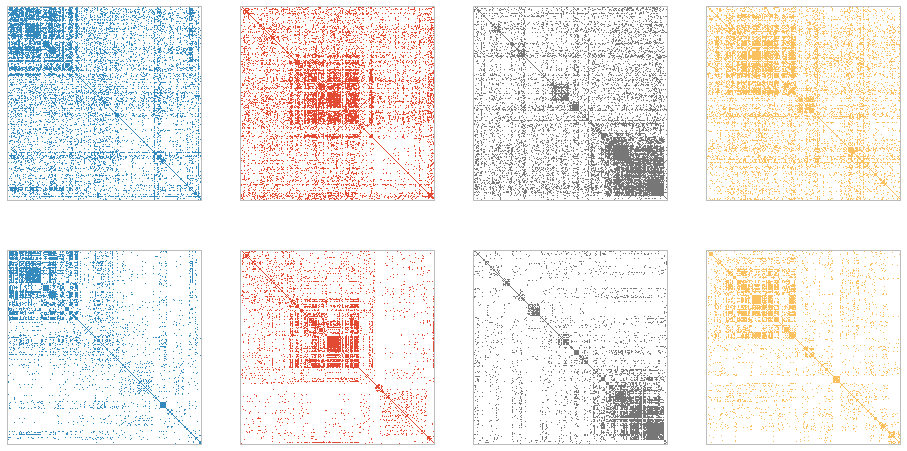

In [31]:
f, ax = plt.subplots(2, 4, figsize=(16, 8))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])

bounds=[0, 0.75, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 0].imshow(local_dist, interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

bounds=[0, 0.85, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 0].imshow(global_dist, interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])

bounds=[0, 0.75, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 1].imshow(local_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

bounds=[0, 0.85, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 1].imshow(global_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][3], 'white'])

bounds=[0, 0.75, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 2].imshow(local_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

bounds=[0, 0.85, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 2].imshow(global_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][4], 'white'])

bounds=[0, 0.75, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 3].imshow(local_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

bounds=[0, 0.85, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 3].imshow(global_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

## Domains

In [17]:
def clan_vs_iter(algnfile):
    """

    """
    with open(algnfile, 'r') as clan_vs_file:
        for line in clan_vs_file:
            word = line.split()
            yield word[0], word[1], float(word[2]), float(word[3]), float(word[4])

In [18]:
import numpy as np
domain_cosine_dist = np.zeros(l * l).reshape(l, l)
domain_euclidean_dist = np.zeros(l * l).reshape(l, l)
domain_hamming_dist = np.zeros(l * l).reshape(l, l)

for rec in clan_vs_iter('pfam.clan.vs'):
    domain_cosine_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = rec[2]
    domain_euclidean_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = rec[3]
    domain_hamming_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = rec[4]

In [19]:
print(domain_cosine_dist.min(), domain_cosine_dist.max())
print(domain_euclidean_dist.min(), domain_euclidean_dist.max())
print(domain_hamming_dist.min(), domain_hamming_dist.max())

(nan, nan)
(0.0, 3.16228)
(0.0, 0.103093)


(-0.01, 1.01)

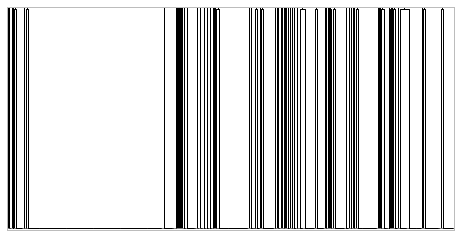

In [20]:
f, ax = plt.subplots(1, 1, figsize=(8, 4))

domain_clusters = hierarchy.linkage(distance.squareform(domain_euclidean_dist), method='complete')
domain_dendo = hierarchy.dendrogram(domain_clusters, color_threshold=np.inf, no_plot=False, ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-0.01, 1.01)

[]

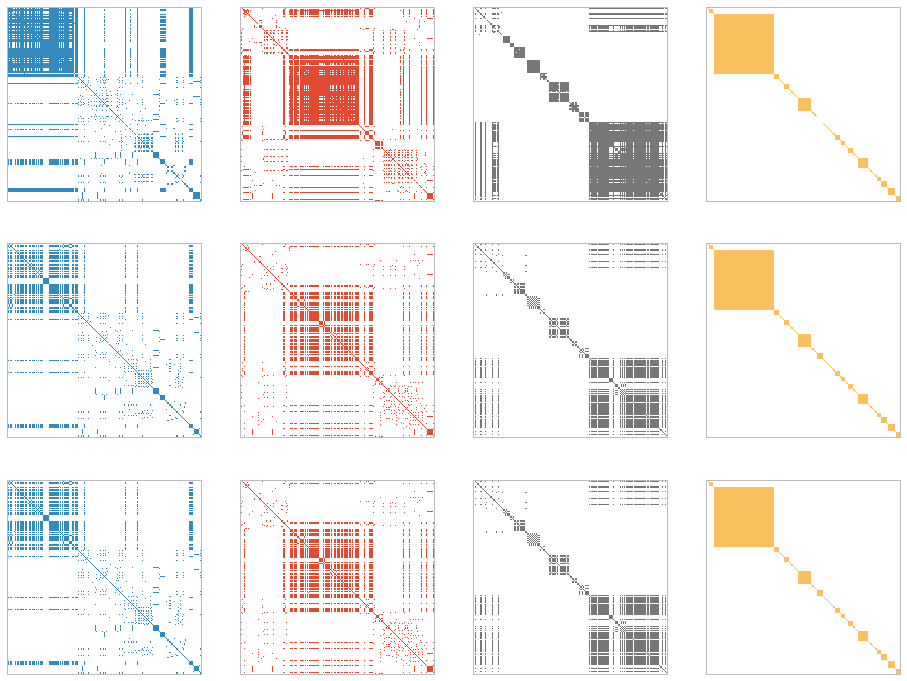

In [21]:
f, ax = plt.subplots(3, 4, figsize=(16, 12))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])

bounds=[0, 0.3, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 0].imshow(domain_cosine_dist, interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

bounds=[0, 1.0, 3.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 0].imshow(domain_euclidean_dist, interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

bounds=[0, 0.01, 0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 0].imshow(domain_hamming_dist, interpolation='nearest', cmap=cmap, norm=norm)
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])

bounds=[0, 0.3, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 1].imshow(domain_cosine_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

bounds=[0, 1.0, 3.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 1].imshow(domain_euclidean_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

bounds=[0, 0.01, 0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 1].imshow(domain_hamming_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][3], 'white'])

bounds=[0, 0.3, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 2].imshow(domain_cosine_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

bounds=[0, 1.0, 3.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 2].imshow(domain_euclidean_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

bounds=[0, 0.01, 0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 2].imshow(domain_hamming_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][4], 'white'])

bounds=[0, 0.2, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 3].imshow(domain_cosine_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

bounds=[0, 1.0, 3.2]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 3].imshow(domain_euclidean_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=3.2)
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

bounds=[0, 0.01, 0.1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 3].imshow(domain_hamming_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=0.1)
ax[2, 3].set_xticks([])
ax[2, 3].set_yticks([])

[]

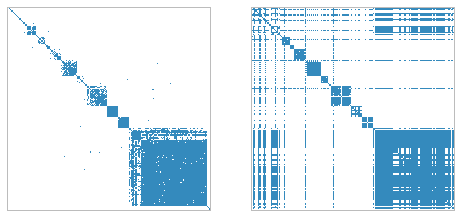

In [22]:
f, ax = plt.subplots(1, 2, figsize=(8, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
bounds=[0, 1, 10]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
bounds=[0, 1.1, 10] # include d < 1.1 (0 and 1 differences)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1].imshow(domain_euclidean_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm)
ax[1].set_xticks([])
ax[1].set_yticks([])

## Bind graphs

In [23]:
def graph_vs_iter(graphfile):
    """

    """
    with open(graphfile, 'r') as graph_vs_file:
        for line in graph_vs_file:
            word = line.split()
            yield word[0], word[1], float(word[2]), float(word[3]), float(word[4])

In [24]:
!head graphs.escore0.35.vs

Q8IKH2	Q8IKH2	1	1	1
Q8IKH2	Q5CTD3	0.566667	0.72631	0.794393
Q8IKH2	P41936	0	0	0
Q8IKH2	P14859	0.0110375	0.0339886	0.0934579
Q8IKH2	O70137	0	0	0
Q8IKH2	O35137	0	0	0
Q8IKH2	O35085	0	0	0
Q8IKH2	P97503	0.00105042	0.00332371	0.00934579
Q8IKH2	P63157	0	0	0
Q8IKH2	Q8VIB5	0	0	0


In [25]:
import numpy as np
graph_jaccard_dist = np.zeros(l * l).reshape(l, l)
graph_cosine_dist = np.zeros(l * l).reshape(l, l)
graph_min_dist = np.zeros(l * l).reshape(l, l)

for rec in graph_vs_iter('graphs.escore0.35.vs'):
    graph_jaccard_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = 1.0 - rec[2]
    graph_cosine_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = 1.0 - rec[3]
    graph_min_dist[uniprot_idx[rec[0]], uniprot_idx[rec[1]]] = 1.0 - rec[4]

In [26]:
print(graph_jaccard_dist.min(), graph_jaccard_dist.max())
print(graph_cosine_dist.min(), graph_cosine_dist.max())
print(graph_min_dist.min(), graph_min_dist.max())

(0.0, 1.0)
(nan, nan)
(nan, nan)


[]

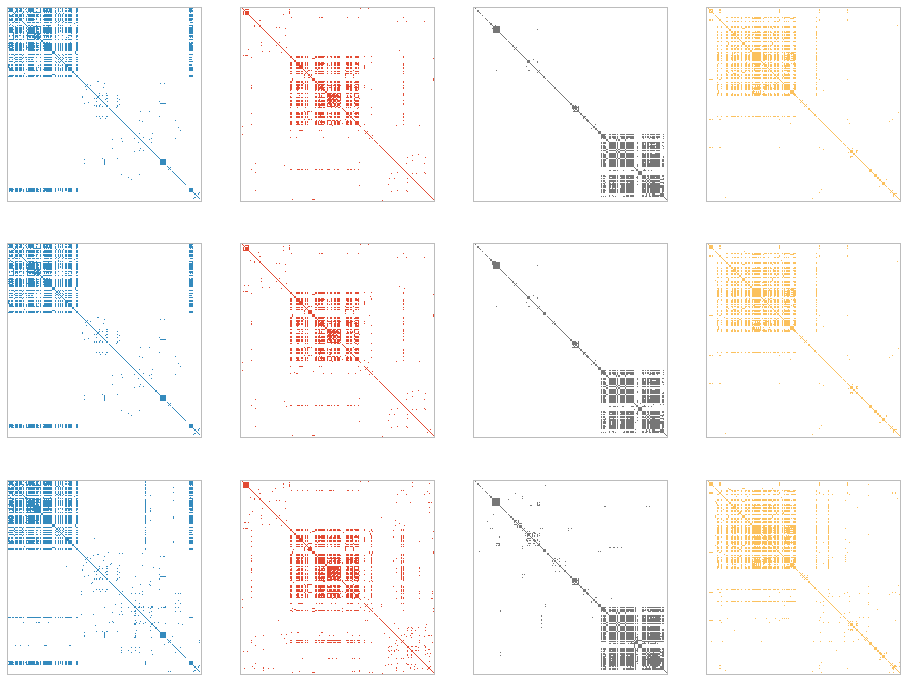

In [27]:
f, ax = plt.subplots(3, 4, figsize=(16, 12))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])

bounds=[0, 0.666, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 0].imshow(graph_jaccard_dist, interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 0].imshow(graph_cosine_dist, interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=2)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 0].imshow(graph_min_dist, interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[2, 0].set_xticks([])
ax[2, 0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])

bounds=[0, 0.666, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 1].imshow(graph_jaccard_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 1].imshow(graph_cosine_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 1].imshow(graph_min_dist[species_dendo['leaves'],:][:,species_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[2, 1].set_xticks([])
ax[2, 1].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][3], 'white'])

bounds=[0, 0.666, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 2].imshow(graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 2].imshow(graph_cosine_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 2].imshow(graph_min_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[2, 2].set_xticks([])
ax[2, 2].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][4], 'white'])

bounds=[0, 0.666, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0, 3].imshow(graph_jaccard_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1, 3].imshow(graph_cosine_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[1, 3].set_xticks([])
ax[1, 3].set_yticks([])

bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2, 3].imshow(graph_min_dist[domain_dendo['leaves'],:][:,domain_dendo['leaves']], interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[2, 3].set_xticks([])
ax[2, 3].set_yticks([])

## VS comparisons

[]

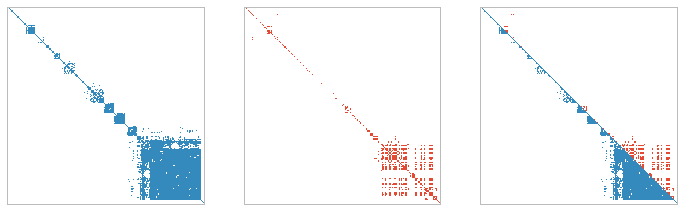

In [28]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white'])
bounds=[0, 1e-4, 10]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']],
             interpolation='nearest', cmap=cmap, norm=norm)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][0], 'white'])
bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1].imshow(graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']],
             interpolation='nearest', cmap=cmap, norm=norm, vmin=0, vmax=1)
ax[1].set_xticks([])
ax[1].set_yticks([])

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white',
                                  'white',
                                  plt.rcParams['axes.color_cycle'][0], 'white'])
bounds=[0, 1e-4, 10, 100, 100.5, 101]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2].imshow(np.tril(escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']], -1) +
             np.triu(graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] + 100.0, 1),
             interpolation='nearest', cmap=cmap, norm=norm)
ax[2].set_xticks([])
ax[2].set_yticks([])

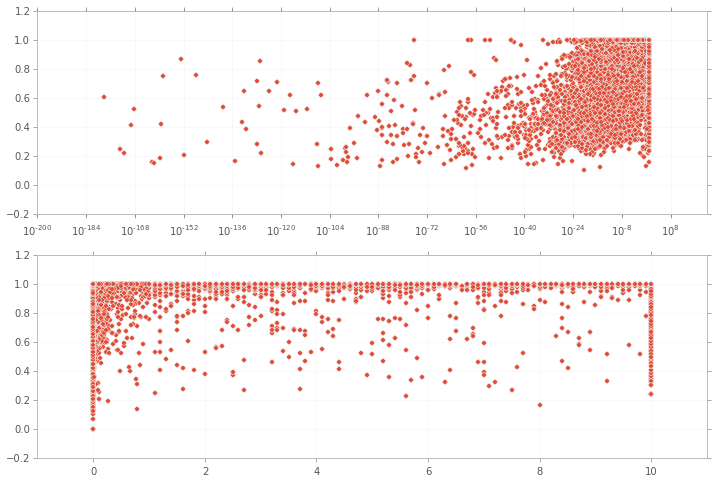

In [32]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].set_xscale('log')
ax[0].set_xlim([1e-200,1e20])
ax[0].scatter(escores.flatten(), graph_jaccard_dist.flatten(), c=plt.rcParams['axes.color_cycle'][0])

ax[1].set_xlim([-1,11])
ax[1].scatter(escores.flatten(), graph_jaccard_dist.flatten(), c=plt.rcParams['axes.color_cycle'][0])

[]

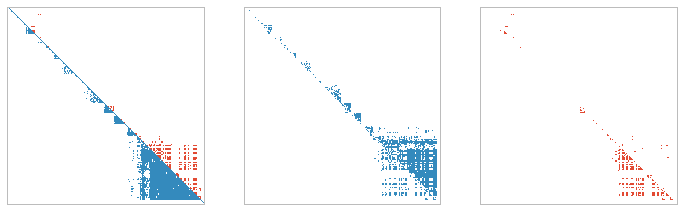

In [33]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))

cmap = mpl.colors.ListedColormap([plt.rcParams['axes.color_cycle'][1], 'white',
                                  'white',
                                  plt.rcParams['axes.color_cycle'][0], 'white'])
bounds=[0, 1e-4, 10, 100, 100.5, 101]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(np.tril(escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']], -1) +
             np.triu(graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] + 100.0, 1),
             interpolation='nearest', cmap=cmap, norm=norm)
ax[0].set_xticks([])
ax[0].set_yticks([])

cmap = mpl.colors.ListedColormap(['white', plt.rcParams['axes.color_cycle'][1]])
bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[1].imshow(np.tril(np.array((escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 1e-4) &
                              (graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 0.5),
                              dtype=np.int8), -1) + 
             np.triu(np.array((escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 1e-4) &
                              (graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] > 0.5),
                              dtype=np.int8), 1),
             interpolation='nearest', cmap=cmap, norm=norm)
ax[1].set_xticks([])
ax[1].set_yticks([])

cmap = mpl.colors.ListedColormap(['white', plt.rcParams['axes.color_cycle'][0]])
bounds=[0, 0.5, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax[2].imshow(np.tril(np.array((escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 1e-4) &
                              (graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 0.5),
                              dtype=np.int8), -1) + 
             np.triu(np.array((escores[escores_dendo['leaves'],:][:,escores_dendo['leaves']] > 1e-4) &
                              (graph_jaccard_dist[escores_dendo['leaves'],:][:,escores_dendo['leaves']] < 0.5),
                              dtype=np.int8), 1),
             interpolation='nearest', cmap=cmap, norm=norm)
ax[2].set_xticks([])
ax[2].set_yticks([])

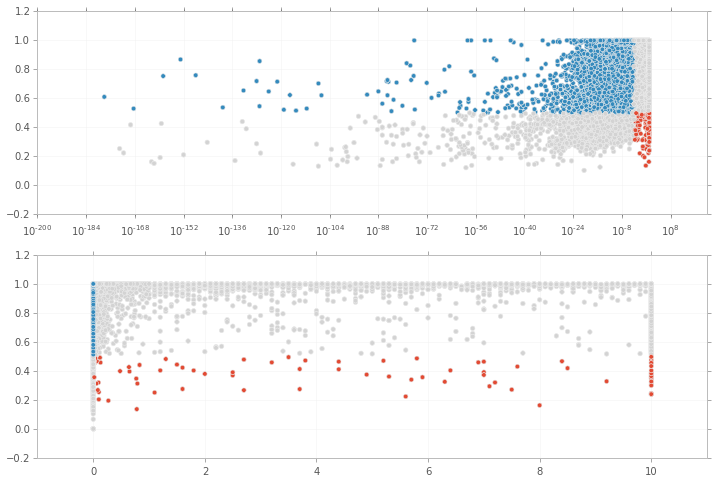

In [34]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))

e = escores.flatten()
j = graph_jaccard_dist.flatten()
c = [(plt.rcParams['axes.color_cycle'][1] if ((e[i] < 1e-4) & (j[i] > 0.5)) else 
      plt.rcParams['axes.color_cycle'][0] if ((e[i] > 1e-4) & (j[i] < 0.5)) else 'LightGray')
     for i in range(len(e))]

ax[0].set_xscale('log')
ax[0].set_xlim([1e-200,1e20])
ax[0].scatter(e, j, c=c)

ax[1].set_xlim([-1, 11])
ax[1].scatter(e, j, c=c)

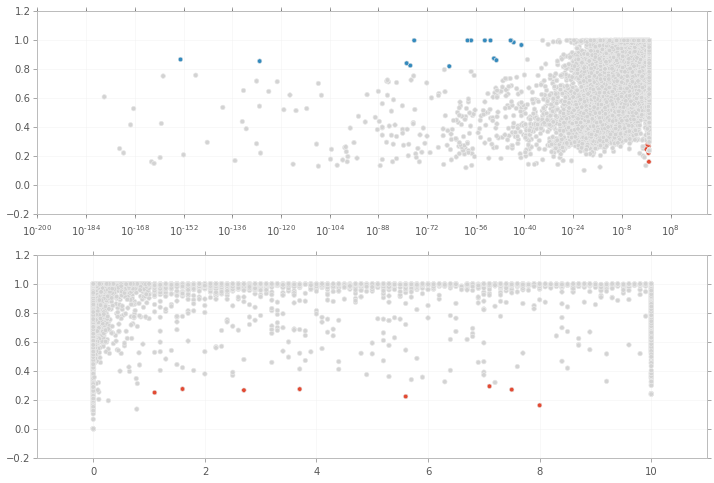

In [142]:
f, ax = plt.subplots(2, 1, figsize=(12, 8))

e = escores.flatten()
j = graph_jaccard_dist.flatten()
c = [(plt.rcParams['axes.color_cycle'][1] if ((e[i] < 1e-40) & (e[i] > 0.0) & (j[i] > 0.8)) else 
      plt.rcParams['axes.color_cycle'][0] if ((e[i] > 1) & (e[i] < 10) & (j[i] < 0.3)) else 'LightGray')
     for i in range(len(e))]

ax[0].set_xscale('log')
ax[0].set_xlim([1e-200,1e20])
ax[0].scatter(e, j, c=c)

ax[1].set_xlim([-1, 11])
ax[1].scatter(e, j, c=c)

In [153]:
lo_escore_hi_dist = np.argwhere((escores < 1e-40) & (escores > 0.0) &
                                (graph_jaccard_dist > 0.8) & (graph_jaccard_dist < 1.0))

In [154]:
lo_escore_hi_dist = [eval(s) for s in {str(sorted([i, j])) for i,j in lo_escore_hi_dist}]

In [155]:
[[idx_uniprot[i], idx_uniprot[j]] for i,j in lo_escore_hi_dist]

[['Q62231', 'Q9Y1P6'],
 ['Q62233', 'Q9Y1P6'],
 ['Q03125', 'P38082'],
 ['P34056', 'Q6VUP9'],
 ['Q5RJ54', 'Q3UHV1'],
 ['Q8VDL9', 'Q62520'],
 ['P46684', 'Q8VDL9'],
 ['Q61312', 'Q6VUP9'],
 ['Q62232', 'Q9Y1P6']]

In [156]:
for i, j in lo_escore_hi_dist:
    print('%d\t%d\t%s\t%s\t%g\t%g' %
          (i, j, idx_uniprot[i], idx_uniprot[j], escores[i, j], graph_jaccard_dist[i, j]))

154	437	Q62231	Q9Y1P6	3e-78	0.826744
156	437	Q62233	Q9Y1P6	2e-65	0.821782
310	404	Q03125	P38082	1e-41	0.968198
203	245	P34056	Q6VUP9	1e-153	0.868794
206	208	Q5RJ54	Q3UHV1	3e-44	0.986965
197	222	Q8VDL9	Q62520	6e-50	0.863572
180	197	P46684	Q8VDL9	1e-50	0.875934
223	245	Q61312	Q6VUP9	1e-127	0.857143
155	437	Q62232	Q9Y1P6	2e-79	0.84273


In [157]:
i, j = 203, 223
print('%d\t%d\t%s\t%s\t%g\t%g' %
      (i, j, idx_uniprot[i], idx_uniprot[j], escores[i, j], graph_jaccard_dist[i, j]))

203	223	P34056	Q61312	1e-173	0.253289


In [136]:
hi_escore_lo_dist = np.argwhere((escores > 1.0) & (escores < 10.0) &
                                (graph_jaccard_dist < 0.3))

In [137]:
hi_escore_lo_dist = [eval(s) for s in {str(sorted([i, j])) for i,j in hi_escore_lo_dist}]

In [145]:
[[idx_uniprot[i], idx_uniprot[j]] for i,j in hi_escore_lo_dist]

[['Q06348', 'O35602'],
 ['O35137', 'O09113'],
 ['Q91ZD1', 'Q9WVG7'],
 ['P63013', 'O35602'],
 ['P63013', 'P70390'],
 ['P09092', 'P23463'],
 ['P02830', 'P23463'],
 ['Q62520', 'Q62521']]

In [141]:
for i, j in hi_escore_lo_dist:
    print('%d\t%d\t%s\t%s\t%g\t%g' %
          (i, j, idx_uniprot[i], idx_uniprot[j], escores[i, j], graph_jaccard_dist[i, j]))

149	150	Q06348	O35602	7.1	0.293844
5	123	O35137	O09113	1.6	0.274809
193	229	Q91ZD1	Q9WVG7	1.1	0.25
148	150	P63013	O35602	3.7	0.273986
148	153	P63013	P70390	5.6	0.223111
54	79	P09092	P23463	7.5	0.270327
55	79	P02830	P23463	2.7	0.266461
222	233	Q62520	Q62521	8	0.1625
